<a href="https://colab.research.google.com/github/mystlee/2024_CSU_AI/blob/main/chapter5/GradCAM_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!fc-cache -fv

import torch
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import cv2

def load_image(url, transform = None):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if transform:
        img_tensor = transform(img).unsqueeze(0)
        return img, img_tensor
    return img

def find_last_conv_layer(model):
    last_conv = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv = module
    return last_conv

model = models.efficientnet_b0(pretrained = True)
model.eval()

target_layer = find_last_conv_layer(model)

activations = {}
gradients = {}

In [43]:
def forward_hook(module, input, output):
    activations['value'] = output.detach()

def backward_hook(module, grad_in, grad_out):
    gradients['value'] = grad_out[0].detach()

forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_backward_hook(backward_hook)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],  # ImageNet 데이터셋의 평균
                         std = [0.229, 0.224, 0.225])    # ImageNet 데이터셋의 표준편차
])

image_url = "https://miro.medium.com/v2/resize:fit:1400/0*MeHk9j_om2Li9jrH.jpg"  # 고양이 사진
original_image, input_tensor = load_image(image_url, transform = preprocess)

output = model(input_tensor)
pred_prob, pred_class = torch.max(output, 1)
print(f"pred. class: {pred_class.item()}, prob.: {pred_prob.item()}")

# pred_class = 230
model.zero_grad()
output[0, pred_class].backward()

activation = activations['value']
gradient = gradients['value']
weights = torch.mean(gradient, dim = (2, 3))
cam = torch.zeros(activation.shape[2:], dtype = torch.float32)

for i, w in enumerate(weights[0]):
    cam += w * activation[0, i, :, :]

cam = torch.relu(cam)
cam = cam - cam.min()
if cam.max() != 0:
    cam = cam / cam.max()
cam = cam.cpu().numpy()
cam = cv2.resize(cam, (original_image.width, original_image.height))

pred. class: 281, prob.: 9.406001091003418


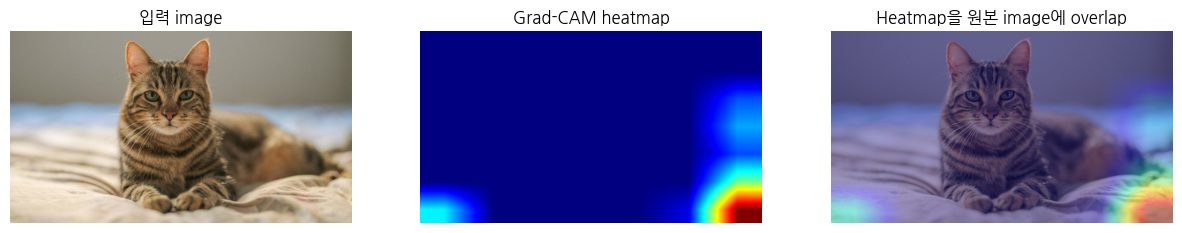

In [42]:
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE
import matplotlib as mpl

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname = font_path, size = 12)
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['NanumGothic'] + mpl.rcParams['font.sans-serif']
mpl.rcParams['axes.unicode_minus'] = False

image_np = np.array(original_image)
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

superimposed_img = heatmap * 0.4 + image_np * 0.6
superimposed_img = superimposed_img / superimposed_img.max()

plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('입력 image', fontproperties = font_prop)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title('Grad-CAM heatmap', fontproperties = font_prop)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title('Heatmap을 원본 image에 overlap', fontproperties = font_prop)
plt.axis('off')

plt.show()

forward_handle.remove()
backward_handle.remove()

In [45]:
import json
import urllib.request

# ImageNet class index 매핑 파일 URL
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

response = urllib.request.urlopen(url)
class_idx = [s.strip() for s in response.read().decode("utf-8").splitlines()]

print(f"Class: {class_idx}")

dog_classes = {}
for idx, label in enumerate(class_idx):
    if "dog" in label:
        dog_classes[idx] = label

print(f"dog가 포함된 class 개수: {len(dog_classes)}")
for idx, label in dog_classes.items():
    print(f"{idx}: {label}")



Class: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'diamond